In [1]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval

import matplotlib.pyplot as plt

import torch
from utils.visualization import show_angle_ratio, show_heatmap_points

In [2]:
predictions = pd.read_csv("./dataset/infer_both_model_efficientnet-b3_size_512.csv")
predictions.head()

,#filename,pred_coords,target_coords
0,patient11187_study1_negative_image3.png,"[315.79998779296875, 180.8000030517578, 297.79...","[319.0, 181.63999938964844, 295.0, 130.4400024..."
1,patient11236_study1_negative_image2.png,"[219.39999389648438, 211.8000030517578, 243.0,...","[219.8800048828125, 210.0, 242.91000366210938,..."
2,patient11236_study1_negative_image3.png,"[234.60000610351562, 252.1999969482422, 255.60...","[235.0, 251.38999938964844, 256.0, 164.8999938..."
3,patient11255_study1_negative_image2.png,"[267.0, 217.0, 271.0, 161.60000610351562, 333....","[268.57000732421875, 218.0, 270.8599853515625,..."
4,patient11267_study2_negative_image2.png,"[137.39999389648438, 237.8000030517578, 157.19...","[139.0, 240.8699951171875, 158.0, 161.41999816..."


## Visualizing Predicted vs Ground Truth points

In [3]:
samples = predictions.sample(4)
paths = [f"./dataset/AP/valid/{filename}" for filename in samples['#filename'].values]
pred_coords = np.array(list(map(literal_eval, samples['pred_coords']))).reshape(-1, 4, 2)
target_coords = np.array(list(map(literal_eval, samples['target_coords']))).reshape(-1, 4, 2)

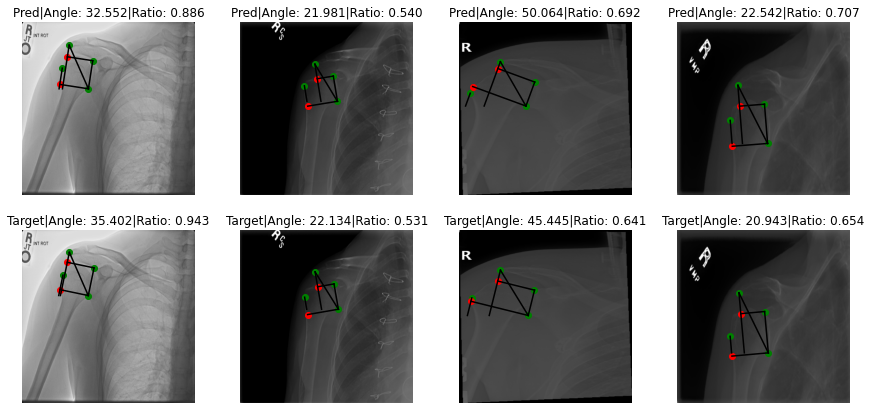

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flatten()
for i, (path, pred, target) in enumerate(zip(paths, pred_coords, target_coords)):
    angle, ratio, _ = show_angle_ratio(path, size=512, points=pred, ax=axes[i], angle=True, verbose=False, return_values=True)
    axes[i].set_title(f"Pred|Angle: {angle:.3f}|Ratio: {ratio:.3f}")
    axes[i].axis("off")
    angle, ratio, _ = show_angle_ratio(path, size=512, points=target, ax=axes[i + 4], angle=True, verbose=False,                                                     return_values=True)
    axes[i + 4].set_title(f"Target|Angle: {angle:.3f}|Ratio: {ratio:.3f}")
    axes[i + 4].axis("off")

fig.savefig("pred_vs_target.png", facecolor="white")

## Loading Predicted Heatmaps

In [5]:
heatmaps = []
for filename in os.listdir("./dataset/heatmaps"):
    heatmaps.append(torch.load(f"./dataset/heatmaps/{filename}"))

# aggregating all the heatmaps via taking the mean of the 5 models' outputs
mean_heatmaps = torch.stack(heatmaps, dim=0).mean(0)

In [6]:
samples = predictions.sample(8)
paths = [f"./dataset/AP/valid/{filename}" for filename in samples['#filename'].values]
pred_coords = np.array(list(map(literal_eval, samples['pred_coords']))).reshape(-1, 4, 2)
target_coords = np.array(list(map(literal_eval, samples['target_coords']))).reshape(-1, 4, 2)
indices = samples.index.tolist()
sample_heatmaps = mean_heatmaps[indices]

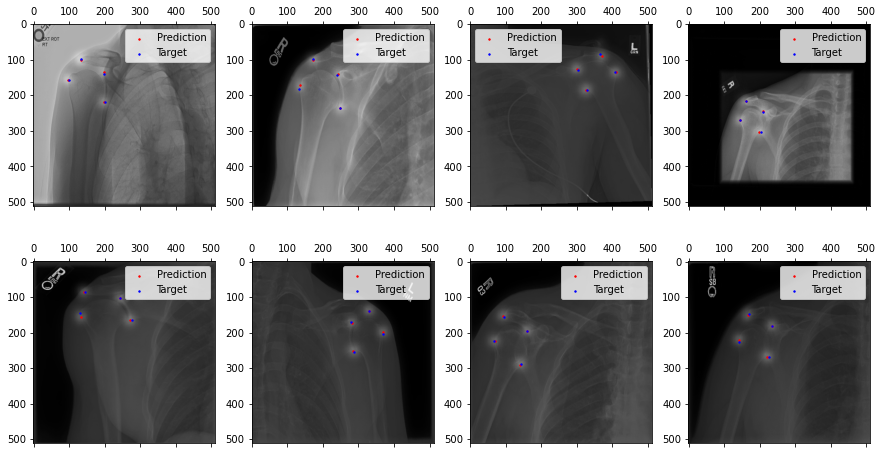

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for ax, path, pred_point, target_point, heatmap in zip(axes.flatten(), 
                                                       paths, 
                                                       pred_coords, 
                                                       target_coords, 
                                                       sample_heatmaps):
                                                       
    show_heatmap_points(path, 512, heatmap, pred_point, target_point, ax=ax)

fig.savefig("heatmap.png", facecolor="white")

In [16]:
def show_heatmap_points(
    image_path,
    size,
    image_heatmaps,
    pred_points,
    target_points=None,
    ax=None,
    alpha=0.2,
):
    """
    image_path: complete path to the image
    image_heatmaps: heatmaps for the image with the shape (4, size, size)
    pred_points: predicted points with shape (4, 2)
    target_points: target points with shape (4, 2)
    """

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))

    image = cv2.imread(image_path)[..., ::-1]
    transform = A.Resize(size, size, always_apply=True)
    image = transform(image=image)["image"]

    ax.imshow(image)
    ax.matshow(image_heatmaps.sum(0), alpha=alpha, cmap="gray")  # could be other things
    ax.scatter(pred_points[:, 0], pred_points[:, 1], s=25, c="r", label="Prediction")
    if target_points is not None:
        ax.scatter(target_points[:, 0], target_points[:, 1], s=25, c="g", label="Target")
    ax.legend()

In [17]:
import cv2
import albumentations as A
import matplotlib.pyplot as plt

def plot(row):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    img = cv2.imread(f"./dataset/AP/valid/{row['#filename']}")[..., ::-1]
    ax.imshow(img)

In [18]:
samples = predictions.iloc[[6, 7, 8, 9, 10, 13, 18, 25, 40, 58, 70, 79, 80]]
paths = [f"./dataset/AP/valid/{filename}" for filename in samples['#filename'].values]
pred_coords = np.array(list(map(literal_eval, samples['pred_coords']))).reshape(-1, 4, 2)
target_coords = np.array(list(map(literal_eval, samples['target_coords']))).reshape(-1, 4, 2)
indices = samples.index.tolist()
sample_heatmaps = mean_heatmaps[indices]

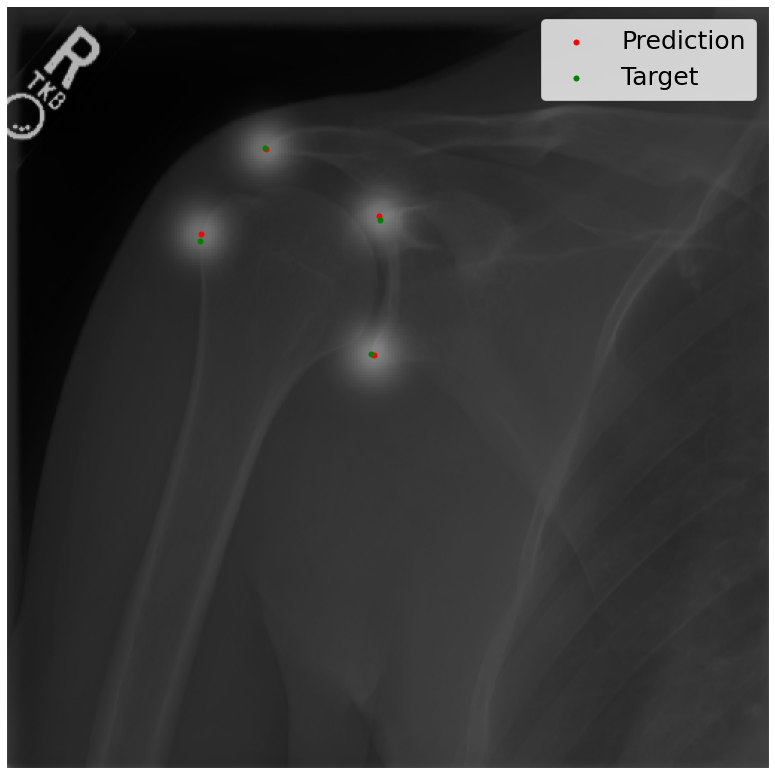

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
idx = -4
show_heatmap_points(paths[idx], 512, sample_heatmaps[idx], pred_coords[idx], target_coords[idx], ax=ax, alpha=0.3)
ax.axis("off")
plt.legend(prop={'size': 25})
fig.savefig("best_heatmap.png")
plt.show()


In [26]:
from utils.measure import get_angle, get_ratio

In [30]:
def show_angle_ratio(
    image_path,
    size,
    points,
    ax=None,
    lines=True,
    angle=False,
    verbose=True,
    return_values=False,
):
    """
    image_path: complete path to the image
    size: must be mentioned for resizing
    points: as array or tensor with shape (4, 2)
    verbose: whether to print out angle and ratio
    """
    image = cv2.imread(image_path)[..., ::-1]
    transform = A.Resize(size, size, always_apply=True)
    image = transform(image=image)["image"]
    alpha = get_angle(points[0], points[1], points[2])
    output = get_ratio(points)
    if verbose:
        print(
            f"Angle (degrees): {alpha:.3f}\n"
            f"AI Ratio: {output['AI_ratio']:.3f}\n"
            f"Is Inf: {output['is_inf']}"
        )

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))

    ax.imshow(image, cmap="gray")
    ax.scatter(points[:, 0], points[:, 1], s=70, c="r", label="Predictions")  # g for main points
    ax.plot(points[[0, 1], 0], points[[0, 1], 1], c="k")
    if lines:
        ax.plot([points[3][0], output["x3_"]], [points[3][1], output["y3_"] - 5], c="k")
        ax.plot([points[0][0], output["x01"]], [points[0][1], output["y01"] - 4], c="k")

        # ax.scatter(
        #     output["x_share3_"], output["y_share3_"], c="r"
        # )  # r for rule-obtained points
        ax.plot(
            [points[0][0], output["x_share3_"]],
            [points[0][1], output["y_share3_"]],
            c="k",
        )

        ax.plot([points[2][0], output["x2_"]], [points[2][1], output["y2_"] - 4], c="k")

        ax.plot(
            [points[1][0], output["x_share2_"]],
            [points[1][1], output["y_share2_"]],
            c="k",
        )
        # ax.scatter(output["x_share2_"], output["y_share2_"], c="r")
    if angle:
        ax.plot(points[[0, 2], 0], points[[0, 2], 1], c="k")

    if return_values:
        return alpha, output["AI_ratio"], output["is_inf"]

In [31]:
samples = predictions.iloc[[6, 7, 8, 9, 10, 13, 18, 25, 40, 58, 70, 79, 80]]
paths = [f"./dataset/AP/valid/{filename}" for filename in samples['#filename'].values]
pred_coords = np.array(list(map(literal_eval, samples['pred_coords']))).reshape(-1, 4, 2)
target_coords = np.array(list(map(literal_eval, samples['target_coords']))).reshape(-1, 4, 2)

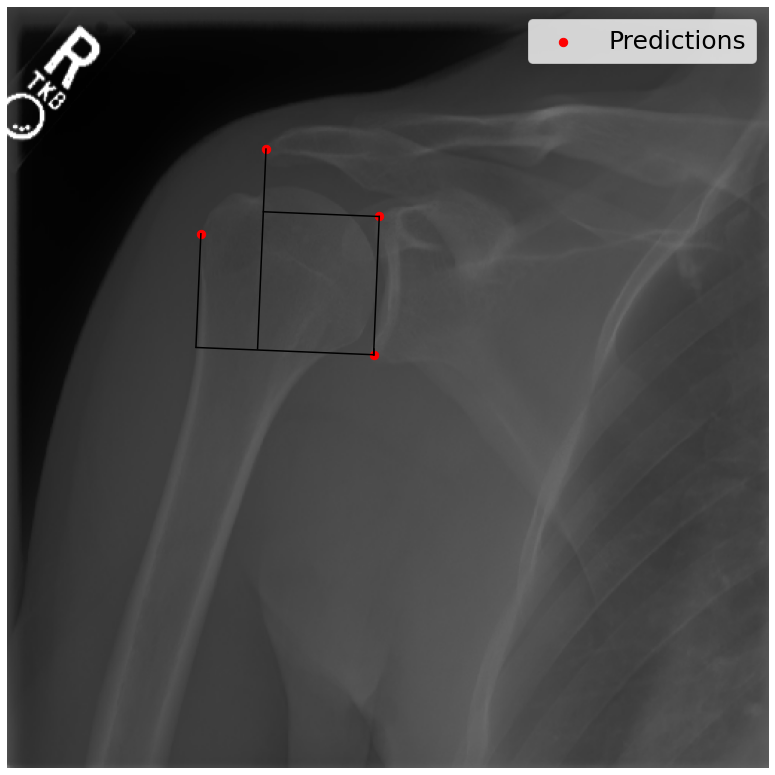

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
idx = -4
show_angle_ratio(paths[idx], size=512, points=pred_coords[idx], ax=ax, angle=False, verbose=False, return_values=False, lines=True)
ax.axis("off")
plt.legend()
plt.legend(prop={'size': 25})
fig.savefig("ratio_lines.png")
plt.show()